In [1]:
# GOES on AWS python utility: https://github.com/palexandremello/goes-py
!pip install goespy

# GOES on AWS: https://docs.opendata.aws/noaa-goes16/cics-readme.html ; https://registry.opendata.aws/noaa-goes/

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
import rasterio as rio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import cartopy.crs as ccrs
from goespy.Downloader import ABI_Downloader # https://github.com/palexandremello/goes-py


======================================== goes-py =========================================
 A Python package can be useful to download dataset from goes satellite on AWS  0.2.1v


In [42]:
def ABIangle2LatLon(x, y, H, req, rpol, lon_0):
    '''Find the latitude and longitude (degrees) of point P given x and y, ABI elevation and scanning angle (radians)'''
    
    # intermediate calculations
    a = np.sin(x)**2 + ( np.cos(x)**2 * ( np.cos(y)**2 + ( req**2 / rpol**2 ) * np.sin(y)**2 ) )
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - req**2

    rs = ( -b - np.sqrt( b**2 - 4*a*c ) ) / ( 2 * a ) # distance from satellite point (S) to P
    
    Sx = rs * np.cos(x) * np.cos(y)
    Sy = -rs * np.sin(x)
    Sz = rs * np.cos(x) * np.sin(y)
    
    # calculate lat and lon
    lat = np.arctan( ( req**2 / rpol**2 ) * ( Sz / np.sqrt( ( H - Sx )**2 + Sy**2 ) ) )
    lat = np.degrees(lat)
    lon = lon_0 - np.arctan( Sy / ( H - Sx ))
    
    return (lat,lon)

In [136]:
bucket = 'noaa-goes16'
year='2019'
month='03'
day='01'
hour='12'
product='ABI-L1b-RadF'
channel='C14'

In [137]:
filepath = '/home/jovyan/goes16/{}/{}/{}/{}/{}/{}/'.format(year,month,day,product,hour,channel)
if not os.path.exists(filepath):
    ABI = ABI_Downloader(bucket,year,month,day,hour,product,channel)

Downloading... the product ABI-L1b-RadF 
OR_ABI-L1b-RadF-M3C14_G16_s20190601245313_e20190601256079_c20190601256144.nc: [##########] 100%  29.736694 MB/29.736694 MB

In [138]:
file_list = os.listdir(filepath)
file_list

['OR_ABI-L1b-RadF-M3C14_G16_s20190601230313_e20190601241079_c20190601241141.nc',
 'OR_ABI-L1b-RadF-M3C14_G16_s20190601245313_e20190601256079_c20190601256144.nc',
 'OR_ABI-L1b-RadF-M3C14_G16_s20190601200313_e20190601211079_c20190601211141.nc',
 'OR_ABI-L1b-RadF-M3C14_G16_s20190601215313_e20190601226079_c20190601226144.nc']

In [139]:
# pick a file from this list
file = filepath + file_list[0]

In [141]:
# open dataset using xarray
c14 = xr.open_dataset(filepath + file_list[0])

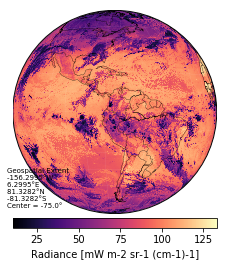

In [158]:
# GNC-A Blog GOES-16 Python Tutorial: Part II
 # https://geonetcast.wordpress.com/2017/04/27/geonetclass-manipulating-goes-16-data-with-python-part-i/
# Required libraries
from netCDF4 import Dataset # Import the NetCDF Python interface
from mpl_toolkits.basemap import Basemap # Import the Basemap toolkit

#####

# Path to the GOES-R simulated image file
path = file
   
# Open the file using the NetCDF4 library
nc = Dataset(path)

# Extract the Radiance values from the NetCDF
data = nc.variables['Rad'][:]
 
# Create the basemap reference for the Satellite Projection
lon0 = c14.goes_imager_projection.longitude_of_projection_origin
lat0 = c14.goes_imager_projection.latitude_of_projection_origin
h = c14.goes_imager_projection.perspective_point_height
bmap = Basemap(projection='geos', lon_0=lon0, lat_0=lat0, satellite_height=h, ellps='GRS80')
 
# Plot GOES-16 Channel using 170 and 378 as the temperature thresholds
bmap.imshow(data, origin='upper', cmap='magma')
 
# Draw the coastlines, countries, parallels and meridians
bmap.drawcoastlines(linewidth=0.3, linestyle='solid', color='black')
bmap.drawcountries(linewidth=0.3, linestyle='solid', color='black')
bmap.drawparallels(np.arange(-90.0, 90.0, 10.0), linewidth=0.1, color='white')
bmap.drawmeridians(np.arange(0.0, 360.0, 10.0), linewidth=0.1, color='white')
 
# Read some variables from the NetCDF header in order to use it in the plot
geo_extent = nc.variables['geospatial_lat_lon_extent']
 
center = str(geo_extent.geospatial_lon_center)
west = str(geo_extent.geospatial_westbound_longitude)
east = str(geo_extent.geospatial_eastbound_longitude)
north = str(geo_extent.geospatial_northbound_latitude)
south = str(geo_extent.geospatial_southbound_latitude)
 
# Put the information retrieved from the header in the final image
plt.text(-300000,300000,'Geospatial Extent \n' + west + '°W \n' + east + '°E \n' + north + '°N \n' + south + '°S \n' + 'Center = ' + center + '°', fontsize = 7)
    
# Insert the legend
bmap.colorbar(location='bottom', label='Radiance [{}]'.format(c14.Rad.units))
 
# Export result
DPI = 300
plt.savefig('GOES-16_Ch14.png', dpi=DPI, bbox_inches='tight', pad_inches=0)
 
# Show the plot
plt.show()